In [102]:
%pip install pmdarima

54226.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.9/591.9 kB 5.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pmdarima]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [114]:
import pandas as pd 
import duckdb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor, XGBClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error


In [41]:
# https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv

df_customers = pd.read_csv("data/olist_customers_dataset.csv")   
df_orders = pd.read_csv("data/olist_orders_dataset.csv")   
df_order_items = pd.read_csv("data/olist_order_items_dataset.csv")
df_geolocation = pd.read_csv("data/olist_geolocation_dataset.csv")   
df_order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")   
df_order_reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")   
df_products = pd.read_csv("data/olist_products_dataset.csv")   
df_sellers = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_trs = pd.read_csv("data/product_category_name_translation.csv")   

In [42]:
query = '''
    select 
    -- o.customer_id, 
    o.customer_unique_id,
        count(distinct o.order_id) as total_orders,
    from df_orders as o 
    left join df_customers as c on o.customer_id = c.customer_id
    group by 1,2 
    having total_orders > 1 
'''
# customers_data = query_for_df(query)
# customers_data


# Exploring data

In [43]:
def query_for_df(query) : 
    con = duckdb.connect()

    # Install + load spatial extension
    con.execute("INSTALL spatial;")
    con.execute("LOAD spatial;")
    query_res = con.execute(query).df()
    return query_res

query = '''
    SELECT customer_id, count(distinct customer_unique_id) count_prd
    from df_customers
    group by 1 
    having count_prd > 1 
''' 

print(query_for_df(query))

Empty DataFrame
Columns: [customer_id, count_prd]
Index: []


In [44]:
query = '''
    select 
    distinct(date_trunc('month', date(order_approved_at))) as order_month
    from df_orders as o 
    order by 1  
'''
# customers_data = query_for_df(query)
# customers_data

months = query_for_df(query)


In [107]:
query = '''
    with months as (
        select 
            distinct order_month
        from months
        where order_month between '2017-01-01' and '2018-08-01'
    ), 

    sellers as (
    SELECT 
        distinct 
        oi.seller_id,
        date_trunc('month', date(o.order_approved_at)) as order_month,
        count(distinct o.order_id) as total_orders,
        sum(coalesce(oi.price,0)) as total_sales_value,
        avg(coalesce(r.review_score,0)) as avg_review_score
    from df_orders o
    left join df_order_items oi on o.order_id = oi.order_id
    left join df_sellers s on oi.seller_id = s.seller_id
    left join df_order_reviews r on o.order_id = r.order_id
    group by 1,2 
    ),

    month_sellers as (
    select distinct m.order_month, s.seller_id
    from months m 
    cross join (select distinct seller_id from sellers) s
    ),

    temp as (
    select 
        a.order_month,
        a.seller_id,
        coalesce(b.total_orders,0) as total_orders,
        coalesce(b.total_sales_value,0) as total_sales_value,
        coalesce(b.avg_review_score,0) as avg_review_score
    from month_sellers a 
    left join sellers b on a.order_month = b.order_month and a.seller_id = b.seller_id
    )

    select 
    *,
    lead(total_orders) over (partition by seller_id order by order_month) next_month_orders,
    case when order_month <= '2018-06-01' then 1 else 0 end is_train_data,
    case when order_month <= '2018-07-01' then 1 else 0 end is_train_data_arima
    from temp 
    ''' 

seller_info = query_for_df(query)

seller_info


,order_month,seller_id,total_orders,total_sales_value,avg_review_score,next_month_orders,is_train_data,is_train_data_arima
0,2017-09-01,804287717b9156fb7a787acd9af4fac1,0,0.0,0.0,0,1,1
1,2017-10-01,804287717b9156fb7a787acd9af4fac1,0,0.0,0.0,0,1,1
2,2017-11-01,804287717b9156fb7a787acd9af4fac1,0,0.0,0.0,0,1,1
3,2017-12-01,804287717b9156fb7a787acd9af4fac1,0,0.0,0.0,0,1,1
4,2018-01-01,804287717b9156fb7a787acd9af4fac1,0,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...
61915,2018-04-01,ff82e8873fba613f2261a9acc896fd84,0,0.0,0.0,0,1,1
61916,2018-05-01,ff82e8873fba613f2261a9acc896fd84,0,0.0,0.0,0,1,1
61917,2018-06-01,ff82e8873fba613f2261a9acc896fd84,0,0.0,0.0,0,1,1
61918,2018-07-01,ff82e8873fba613f2261a9acc896fd84,0,0.0,0.0,0,0,1


In [47]:
query = '''
with 
seller_info_cte as (
    select * 
    from seller_info
    where is_train_data = 1 
), 

min_max_sellers as (
    select 
        seller_id, 
        sum(case when row_asc_sales = 1 then total_orders end) earliest_sales, 
        sum(case when row_desc_sales = 1 then total_orders end) latest_sales
    from (
        select *, 
        row_number() over (partition by seller_id order by order_month) row_asc_sales,
        row_number() over (partition by seller_id order by order_month desc) row_desc_sales,
        from seller_info_cte
        where total_orders > 0 
    )
    group by 1 
), 

sellers_info as (
    select 
        a.seller_id, 
        sum(coalesce(total_sales_value,0)) as total_revenue,
        sum(coalesce(total_sales_value,0)) / sum(coalesce(total_orders,0)) as total_aov, 
        stddev(case when total_sales_value > 0 then (next_month_orders - total_orders)/total_orders end) volatility,
        sum((latest_sales - earliest_sales) / earliest_sales) growth, 
        count(distinct case when total_orders > 0 then order_month end) cnt_active_months
    from seller_info_cte a 
    left join min_max_sellers b on a.seller_id = b.seller_id 
    group by 1 
)

select 
    seller_id, 
    total_revenue,
    total_aov,
    coalesce(volatility,0) volatility, 
    growth, 
    cnt_active_months
from sellers_info
where total_revenue > 0 
'''

sellers_data = query_for_df(query)
sellers_data

,seller_id,total_revenue,total_aov,volatility,growth,cnt_active_months
0,a7c53f6b3b61adbdaa99dda97e8cbd56,99.00,99.000000,0.000000,0.0,1
1,ab75b89cc49c9ab3160d0c91565a442a,37.98,18.990000,0.000000,0.0,2
2,aba1721a889e04decc910aa13b768ef4,13287.30,170.350000,1.306578,76.0,18
3,ac1ed5fc15901fbc92920361eb4ab350,110.25,110.250000,0.000000,0.0,1
4,ad273c9eb54ecb4532de4bf75bae9e4e,556.00,61.777778,0.517549,-9.5,8
...,...,...,...,...,...,...
2902,270297ead4c65a6cd2593960d2af6b21,8223.40,483.729412,0.532943,38.0,10
2903,28c7d8743fbc8679f484868cc0fcaefb,148.50,74.250000,0.707107,0.0,2
2904,2953ce3a88f5e3c3b696d77fc9e4c8eb,230.00,38.333333,0.946485,19.0,4
2905,29fe9f200d3fa0c668d2aa1ec7e08dfb,400.00,80.000000,0.478714,-9.5,4


In [48]:
sellers_data.describe()

,total_revenue,total_aov,volatility,growth,cnt_active_months
count,2907.000000,2907.000000,2907.000000,2907.000000,2907.000000
mean,4376.035150,194.967697,0.764455,11.651546,5.163055
std,13725.368266,345.677832,1.065615,47.606552,4.766275
min,3.500000,3.500000,0.000000,-18.406250,1.000000
25%,203.500000,61.255775,0.000000,0.000000,1.000000
50%,799.000000,107.738462,0.607493,0.000000,3.000000
75%,3302.830000,193.146461,1.060660,9.500000,7.000000
max,214905.230000,6729.000000,20.808896,1197.000000,19.000000


# Clustering Sellers

In [49]:
seller_ids = sellers_data['seller_id']
X = sellers_data.drop(columns=['seller_id'])

# 2 Standardize features (IMPORTANT for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3 Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Add labels back into DataFrame
X["Cluster"] = labels.astype(int)
X["seller_id"] = seller_ids

numeric_cols = X.select_dtypes(include=["float64", "int64"])
cluster_summary = numeric_cols.groupby(X["Cluster"]).mean()
cluster_summary.round(2)


,total_revenue,total_aov,volatility,growth,cnt_active_months,Cluster
Cluster,,,,,,
0,1082.89,157.48,0.49,2.92,3.07,0.0
1,14792.33,157.98,1.68,41.38,12.26,1.0
2,8665.25,1909.82,0.43,0.55,2.84,2.0


- Cluster 0 --> Low Volume sellers / new sellers 
- Cluster 1 --> Active sellers
- Cluster 2 --> Seasonal sellers 

In [50]:
active_sellers = X[X['Cluster']==1].seller_id
seasonal_sellers = X[X['Cluster']==2].seller_id

# Model for Active Sellers

In [128]:
active_sellers_df = seller_info[seller_info['seller_id'].isin(active_sellers) & seller_info['is_train_data_arima'] == 1].reset_index(drop=True)

def arima_forecast(series, forecast_months=1):

    # Fit ARIMA model (simple example: order=(1,1,1))
    model = ARIMA(series, order=(1,1,1))
    model_fit = model.fit()

    # Forecast next month(s)
    forecast = model_fit.forecast(steps=forecast_months)
    return forecast.values[0] 

forecast_results = []

for seller in active_sellers : 
    # print(seller)
    f = arima_forecast(active_sellers_df[active_sellers_df['seller_id']==seller].sort_values('order_month')['total_orders'])
    forecast_results.append({'seller_id': seller, 'next_month_forecast': f})
forecast_df = pd.DataFrame(forecast_results)
print(forecast_df)

/Users/cynthiaathena/Documents/S2/School/242A/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/cynthiaathena/Documents/S2/School/242A/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/cynthiaathena/Documents/S2/School/242A/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/cynthiaathena/Documents/S2/

                            seller_id  next_month_forecast
0    aba1721a889e04decc910aa13b768ef4             4.628496
1    afe0067131b73e40875c9b6c10bd2e21             0.387421
2    bacb1f0ed56ad24198f5810d2b3fe9a5             0.000060
3    cac4c8e7b1ca6252d8f20b2fc1a2e4af             4.886937
4    cce6ab8d1682639fe45ab70234f1665f             2.153502
..                                ...                  ...
659  06a2c3af7b3aee5d69171b0e14f0ee87            73.557021
660  0ea22c1cfbdc755f86b9b54b39c16043             2.910618
661  0ef83d7d83ed97cd2a0049ac8be5f88a             1.379532
662  1ca7077d890b907f89be8c954a02686a             3.130863
663  270297ead4c65a6cd2593960d2af6b21             1.166650

[664 rows x 2 columns]


/Users/cynthiaathena/Documents/S2/School/242A/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/cynthiaathena/Documents/S2/School/242A/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/cynthiaathena/Documents/S2/School/242A/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/cynthiaathena/Documents/S2/

In [129]:
query = '''
with base as (
    SELECT 
        distinct 
        oi.seller_id,
        date_trunc('month', date(o.order_approved_at)) as order_month,
        count(distinct o.order_id) as total_orders
    from df_orders o
    left join df_order_items oi on o.order_id = oi.order_id
    left join df_sellers s on oi.seller_id = s.seller_id
    where date_trunc('month',date(o.order_approved_at)) = '2018-08-01'
    group by 1,2 
)
select 
    a.seller_id,
    a.next_month_forecast, 
    coalesce(b.total_orders,0) next_month_real, 
    
from forecast_df a 
left join base b on a.seller_id = b.seller_id
'''

final_y = query_for_df(query)
final_y

,seller_id,next_month_forecast,next_month_real
0,8e8a7ce9f2f970dc00e2acf6f6e199f6,11.024519,10
1,b499c00f28f4b7069ff6550af8c1348a,11.720338,14
2,4e17c65a516f69d023a2ae78b84f28d6,4.551715,5
3,3bb548e3cb7f70f28e3f11ee9dce0e59,4.195114,1
4,f214d28e8d8e3ef068748498ccc2f813,4.564188,4
...,...,...,...
659,8931a84a914b3fe9b1ddaa4d704947ca,1.526057,0
660,00fc707aaaad2d31347cf883cd2dfe10,3.659866,0
661,0df3984f9dfb3d49ac6366acbd3bbb85,1.936744,0
662,10076e5788b8ee532724bcd460baf762,1.140876,0


In [130]:
y_true = final_y.next_month_real
y_pred = final_y.next_month_forecast

print(f"Mean of True Y test: {y_true.mean():.2f}")
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("============== OVERALL ONE-MONTH FORECAST PERFORMANCE ==============")
print(f"MAE :  {mae:.2f}")
print(f"R2 Score:  {r2:.2f}")

print("\nPreview:")
print(final_y.head())

Mean of True Y test: 6.02
============== OVERALL ONE-MONTH FORECAST PERFORMANCE ==============
MAE :  3.33
R2 Score:  0.64

Preview:
                          seller_id  next_month_forecast  next_month_real
0  8e8a7ce9f2f970dc00e2acf6f6e199f6            11.024519               10
1  b499c00f28f4b7069ff6550af8c1348a            11.720338               14
2  4e17c65a516f69d023a2ae78b84f28d6             4.551715                5
3  3bb548e3cb7f70f28e3f11ee9dce0e59             4.195114                1
4  f214d28e8d8e3ef068748498ccc2f813             4.564188                4


In [133]:
active_sellers_df['lag1'] = active_sellers_df.groupby('seller_id')['total_orders'].shift(1)
active_sellers_df['lag2'] = active_sellers_df.groupby('seller_id')['total_orders'].shift(2)
active_sellers_df['lag3'] = active_sellers_df.groupby('seller_id')['total_orders'].shift(3)

active_sellers_df['ma3'] = active_sellers_df.groupby('seller_id')['total_orders'].shift(1).rolling(3).mean()
active_sellers_df['ma6'] = active_sellers_df.groupby('seller_id')['total_orders'].shift(1).rolling(6).mean()

col_selected = ['lag1','lag2','lag3','ma3','ma6','total_orders']
x_train = active_sellers_df[active_sellers_df.is_train_data==1][col_selected]
y_train = active_sellers_df[active_sellers_df.is_train_data==1]['next_month_orders']

x_test = active_sellers_df[active_sellers_df.is_train_data==0][col_selected]
y_test = active_sellers_df[(active_sellers_df.is_train_data==0) & (active_sellers_df.order_month!='2018-08-01')]['next_month_orders']

xgb = XGBRegressor().fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)

rf = RandomForestRegressor().fit(x_train, y_train)
pred_rf = rf.predict(x_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
r2_xgb = r2_score(y_test, pred_xgb)

mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print(f"Mean of True Y test: {y_test.mean():.2f}")
print("============== OVERALL ONE-MONTH FORECAST PERFORMANCE ==============")
print(f"MAE XGB:  {mae_xgb:.2f}")
print(f"R2 Score XGB:  {r2_xgb:.2f}")

print(f"MAE RF :  {mae_rf:.2f}")
print(f"R2 Score RF:  {r2_rf:.2f}")

print(f'The true y : {y_test[:5].values}')
print(pred_xgb[:5])
print(pred_rf[:5])

Mean of True Y test: 6.02
============== OVERALL ONE-MONTH FORECAST PERFORMANCE ==============
MAE XGB:  3.25
R2 Score XGB:  0.77
MAE RF :  3.17
R2 Score RF:  0.79
The true y : <IntegerArray>
[0, 2, 0, 10, 24]
Length: 5, dtype: Int64
[ 0.12630695  1.5253556   4.307036   20.559786   14.246085  ]
[ 0.063       0.33122222  5.37       12.65       15.73666667]


# Model for Seasonal Sellers

In [54]:
seasonal_sellers_df = seller_info[seller_info['seller_id'].isin(seasonal_sellers)].reset_index(drop=True)

seasonal_sellers_df['month'] = seasonal_sellers_df['order_month'].dt.month
seasonal_sellers_df['year'] = seasonal_sellers_df['order_month'].dt.year

seasonal_sellers_df['is_jan'] = np.where(seasonal_sellers_df['month'] == 1, 1, 0)
seasonal_sellers_df['is_feb'] = np.where(seasonal_sellers_df['month'] == 2, 1, 0)
seasonal_sellers_df['is_mar'] = np.where(seasonal_sellers_df['month'] == 3, 1, 0)
seasonal_sellers_df['is_apr'] = np.where(seasonal_sellers_df['month'] == 4, 1, 0)
seasonal_sellers_df['is_may'] = np.where(seasonal_sellers_df['month'] == 5, 1, 0)
seasonal_sellers_df['is_jun'] = np.where(seasonal_sellers_df['month'] == 6, 1, 0)
seasonal_sellers_df['is_jul'] = np.where(seasonal_sellers_df['month'] == 7, 1, 0)
seasonal_sellers_df['is_aug'] = np.where(seasonal_sellers_df['month'] == 8, 1, 0)
seasonal_sellers_df['is_sep'] = np.where(seasonal_sellers_df['month'] == 9, 1, 0)
seasonal_sellers_df['is_oct'] = np.where(seasonal_sellers_df['month'] == 10, 1, 0)
seasonal_sellers_df['is_nov'] = np.where(seasonal_sellers_df['month'] == 11, 1, 0)
seasonal_sellers_df['is_dec'] = np.where(seasonal_sellers_df['month'] == 12, 1, 0)

seasonal_sellers_df['lag1'] = seasonal_sellers_df.groupby('seller_id')['total_orders'].shift(1)
seasonal_sellers_df['lag2'] = seasonal_sellers_df.groupby('seller_id')['total_orders'].shift(2)
seasonal_sellers_df['lag3'] = seasonal_sellers_df.groupby('seller_id')['total_orders'].shift(3)

seasonal_sellers_df['ma3'] = seasonal_sellers_df.groupby('seller_id')['total_orders'].shift(1).rolling(3).mean()
seasonal_sellers_df['ma6'] = seasonal_sellers_df.groupby('seller_id')['total_orders'].shift(1).rolling(6).mean()


seasonal_sellers_df

,order_month,seller_id,total_orders,total_sales_value,avg_review_score,next_month_orders,is_train_data,month,year,is_jan,...,is_aug,is_sep,is_oct,is_nov,is_dec,lag1,lag2,lag3,ma3,ma6
0,2017-01-01,1d0997ff06b524ce9289ffd75114ecd3,1,1999.0,5.0,0,1,1,2017,1,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2017-02-01,1d0997ff06b524ce9289ffd75114ecd3,0,0.0,0.0,1,1,2,2017,0,...,0,0,0,0,0,1.0,NaN,NaN,NaN,NaN
2,2017-03-01,1d0997ff06b524ce9289ffd75114ecd3,1,1199.0,5.0,0,1,3,2017,0,...,0,0,0,0,0,0.0,1.0,NaN,NaN,NaN
3,2017-04-01,1d0997ff06b524ce9289ffd75114ecd3,0,0.0,0.0,0,1,4,2017,0,...,0,0,0,0,0,1.0,0.0,1.0,0.666667,NaN
4,2017-05-01,1d0997ff06b524ce9289ffd75114ecd3,0,0.0,0.0,0,1,5,2017,0,...,0,0,0,0,0,0.0,1.0,0.0,0.333333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,2018-04-01,d63c73efd41eb002280e7ec831424edb,0,0.0,0.0,1,1,4,2018,0,...,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.166667
1236,2018-05-01,d63c73efd41eb002280e7ec831424edb,1,2699.0,5.0,0,1,5,2018,0,...,0,0,0,0,0,0.0,0.0,0.0,0.000000,0.166667
1237,2018-06-01,d63c73efd41eb002280e7ec831424edb,0,0.0,0.0,0,1,6,2018,0,...,0,0,0,0,0,1.0,0.0,0.0,0.333333,0.166667
1238,2018-07-01,d63c73efd41eb002280e7ec831424edb,0,0.0,0.0,0,1,7,2018,0,...,0,0,0,0,0,0.0,1.0,0.0,0.333333,0.166667


============== GLOBAL CHURN PREDICTION ==============
Accuracy Score XGB:  0.85
Accuracy Score RF:  0.82
Macro F1-Score XGB: 0.6587
Macro F1-Score RF: 0.6251

Preview of predictions:
                             seller_id  have_sales_next_month  pred_xgb  \
19    1d0997ff06b524ce9289ffd75114ecd3                      0         0   
39    5d9f3746e112e696f98ea22c56b3e912                      0         0   
59    5d378b73ab7dd6f0418d743e5dcb0bd1                      0         0   
79    87b740daf17b5d1be335a64164ec6842                      0         0   
99    c510bc1718f0f2961eaa42a23330681a                      1         0   
...                                ...                    ...       ...   
1159  c7b7db6c8f3c64a7cc1afa634db21d50                      0         0   
1179  54219883e72aad869adfb2a54b7bfa0f                      0         0   
1199  a63bfbaa882c8f4542891b4e2246cc7f                      1         0   
1219  b1b3948701c5c72445495bd161b83a4c                      0      

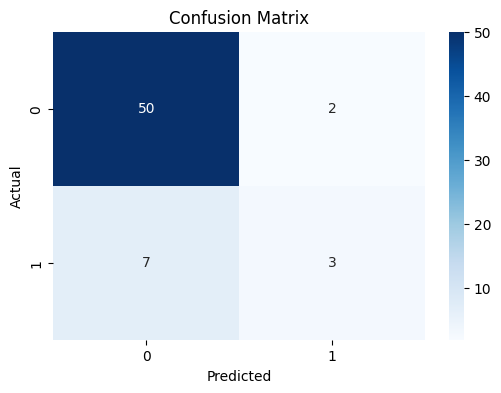

[[48  4]
 [ 7  3]]


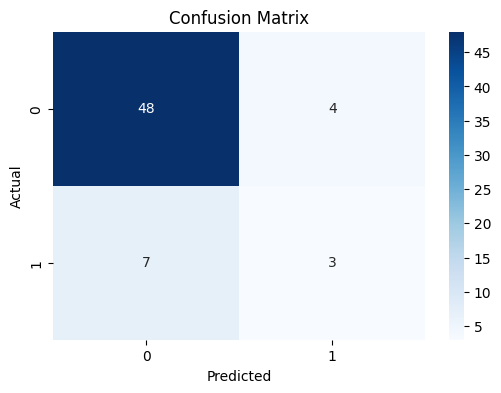

In [61]:
feature_cols = ['is_jan','is_feb','is_mar','is_apr','is_may','is_jun','is_jul','is_aug','is_sep',
                'is_oct','is_nov','is_dec','year','lag1','lag2','lag3']

train_df = seasonal_sellers_df[seasonal_sellers_df.is_train_data == 1].fillna(0)
test_df = seasonal_sellers_df[seasonal_sellers_df.is_train_data == 0].fillna(0)

train_df['have_sales_next_month'] = np.where(train_df['total_orders'] > 0, 1,0) 
test_df['have_sales_next_month'] = np.where(test_df['total_orders'] > 0, 1,0)

X_train = train_df[feature_cols]
y_train = train_df['have_sales_next_month']

X_test  = test_df[feature_cols]
y_test  = test_df['have_sales_next_month']

model_xgb = XGBClassifier().fit(X_train,y_train)
model_rf = RandomForestClassifier().fit(X_train, y_train)

test_df['pred_xgb'] = model_xgb.predict(X_test)
test_df['pred_rf'] = model_rf.predict(X_test)

# =====================================================
# 7. GLOBAL PERFORMANCE METRICS
# =====================================================
accuracy_xgb = accuracy_score(y_test, test_df.pred_xgb)
accuracy_rf = accuracy_score(y_test, test_df.pred_rf)

f1_score_xgb = f1_score(y_test, test_df.pred_xgb, average='macro')
f1_score_rf = f1_score(y_test, test_df.pred_rf, average='macro')

print("============== GLOBAL CHURN PREDICTION ==============")
print(f"Accuracy Score XGB:  {accuracy_xgb :.2f}")
print(f"Accuracy Score RF:  {accuracy_rf :.2f}")

print(f"Macro F1-Score XGB: {f1_score_xgb:.4f}")
print(f"Macro F1-Score RF: {f1_score_rf:.4f}")

print("\nPreview of predictions:")
print(test_df[['seller_id','have_sales_next_month','pred_xgb','pred_rf']])


cm = confusion_matrix(y_test, test_df.pred_xgb)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

cm = confusion_matrix(y_test, test_df.pred_rf)
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()